# Clustering democracy: Turning data into political insight

The Economist Intelligence Unit's Democracy Index presents a unique analytical opportunity at the intersection of data science and political science. By applying clustering techniques to this multidimensional data, you can uncover patterns that extend beyond traditional regime classifications and develop nuanced insights into global democratic systems. This comprehensive guide provides research-backed best practices for preprocessing, clustering, visualizing, and interpreting democracy data to create a professional-quality Jupyter notebook that stands out both academically and professionally.

## The multidimensional nature of democracy measurement

The Democracy Index quantifies democratic quality across five key dimensions: electoral process and pluralism, functioning of government, political participation, political culture, and civil liberties. This multidimensionality makes it particularly suitable for clustering analysis, which can reveal natural groupings beyond the Index's four categorical regime types (full democracies, flawed democracies, hybrid regimes, and authoritarian regimes).

Contemporary political science increasingly recognizes that democracy functions as both a spectrum and a set of distinct typologies. While the Economist Intelligence Unit uses score thresholds to create categories, statistical clustering can identify more nuanced patterns that reflect how different components of democracy interact. This approach aligns with current academic thinking that democracy involves inherent trade-offs between different values, leading to distinct "democracy profiles" rather than a simple linear progression.

## Data preprocessing for democracy index analysis

### Understanding the structure of democracy data

The Democracy Index dataset consists of country-level scores across five dimensions, plus an overall score. Before applying clustering techniques, you need to understand this structure and prepare the data appropriately:

In [25]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [5]:
file_path = "/Users/rosalinatorres/Downloads/democracy_index.csv"
df = pd.read_csv(file_path)

df.head()

,Unnamed: 0,rank,country,democracy_index,electoral_processand_pluralism,functioning_of_government,political_participation,political_culture,civil_liberties,category
0,0,1,Norway,9.87,10.00,9.64,10.00,10.00,9.71,Full democracy
1,1,2,Iceland,9.58,10.00,9.29,8.89,10.00,9.71,Full democracy
2,2,3,Sweden,9.39,9.58,9.64,8.33,10.00,9.41,Full democracy
3,3,4,New Zealand,9.26,10.00,9.29,8.89,8.13,10.00,Full democracy
4,4,5,Denmark,9.22,10.00,9.29,8.33,9.38,9.12,Full democracy


In [6]:
# Basic exploration to understand structure
print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"Number of countries: {df['country'].nunique()}")
# Remove or comment this line:
# print(f"Years available: {df['year'].unique()}")


# 3. Clean column names
df.columns = [col.strip().lower().replace(" ", "_") for col in df.columns]
df.rename(columns={'electoral_processand_pluralism': 'electoral_process_and_pluralism'}, inplace=True)

# Check for missing values
missing_values = df.isnull().sum()
print(f"Missing values per column:\n{missing_values}")

Dataset shape: (167, 13)
Columns: ['unnamed:_0', 'rank', 'country', 'democracy_index', 'electoral_process_and_pluralism', 'functioning_of_government', 'political_participation', 'political_culture', 'civil_liberties', 'category', 'liberty_governance_ratio', 'participation_culture_ratio', 'category_numeric']
Number of countries: 167
Missing values per column:
unnamed:_0                         0
rank                               0
country                            0
democracy_index                    0
electoral_process_and_pluralism    0
functioning_of_government          0
political_participation            0
political_culture                  0
civil_liberties                    0
category                           0
liberty_governance_ratio           0
participation_culture_ratio        0
category_numeric                   0
dtype: int64


### Cleaning and preprocessing steps

Democracy data requires specific preprocessing approaches:

1. **Handling missing values**: For time-series democracy data, forward/backward fill is often more appropriate than mean imputation, as it preserves country-specific patterns.

2. **Feature scaling**: Standardization is essential since the dimensions have similar scales but different distributions.

3. **Handling temporal aspects**: If using multiple years, you'll need to decide whether to cluster countries at specific time points or track changes over time.

In [7]:
# Handle missing values (no time series in this dataset)
# Remove the sort_values since there's no 'year' column
df = df.ffill()

# For any remaining gaps, use mean imputation
dimensions = ['electoral_processand_pluralism', 'functioning_of_government', 
              'political_participation', 'political_culture', 'civil_liberties']
imputer = SimpleImputer(strategy='mean')
df[dimensions] = imputer.fit_transform(df[dimensions])

# Standardize dimensions for clustering
scaler = StandardScaler()
X = df[dimensions]  # Select only the dimension columns for analysis
X_scaled = scaler.fit_transform(X)

# Convert the scaled data back to a DataFrame for easier inspection (optional)
df_scaled = pd.DataFrame(X_scaled, columns=dimensions, index=df.index)

# Add non-scaled columns back for context (like country and category)
df_scaled[['country', 'category', 'democracy_index']] = df[['country', 'category', 'democracy_index']]

# Verify the scaling
print("\nFeature Means after Scaling (should be close to 0):")
print(df_scaled[dimensions].mean().round(4))
print("\nFeature Standard Deviations after Scaling (should be close to 1):")
print(df_scaled[dimensions].std().round(4))

# Display the first few rows of the scaled data
print("\nFirst 5 rows of Scaled Data (with country/category for context):")
print(df_scaled[['country', 'category'] + dimensions].head())


Feature Means after Scaling (should be close to 0):
electoral_processand_pluralism    0.0
functioning_of_government         0.0
political_participation          -0.0
political_culture                -0.0
civil_liberties                   0.0
dtype: float64

Feature Standard Deviations after Scaling (should be close to 1):
electoral_processand_pluralism    1.003
functioning_of_government         1.003
political_participation           1.003
political_culture                 1.003
civil_liberties                   1.003
dtype: float64

First 5 rows of Scaled Data (with country/category for context):
       country        category  electoral_processand_pluralism  \
0       Norway  Full democracy                        1.160785   
1      Iceland  Full democracy                        1.160785   
2       Sweden  Full democracy                        1.041790   
3  New Zealand  Full democracy                        1.160785   
4      Denmark  Full democracy                        1.160785  

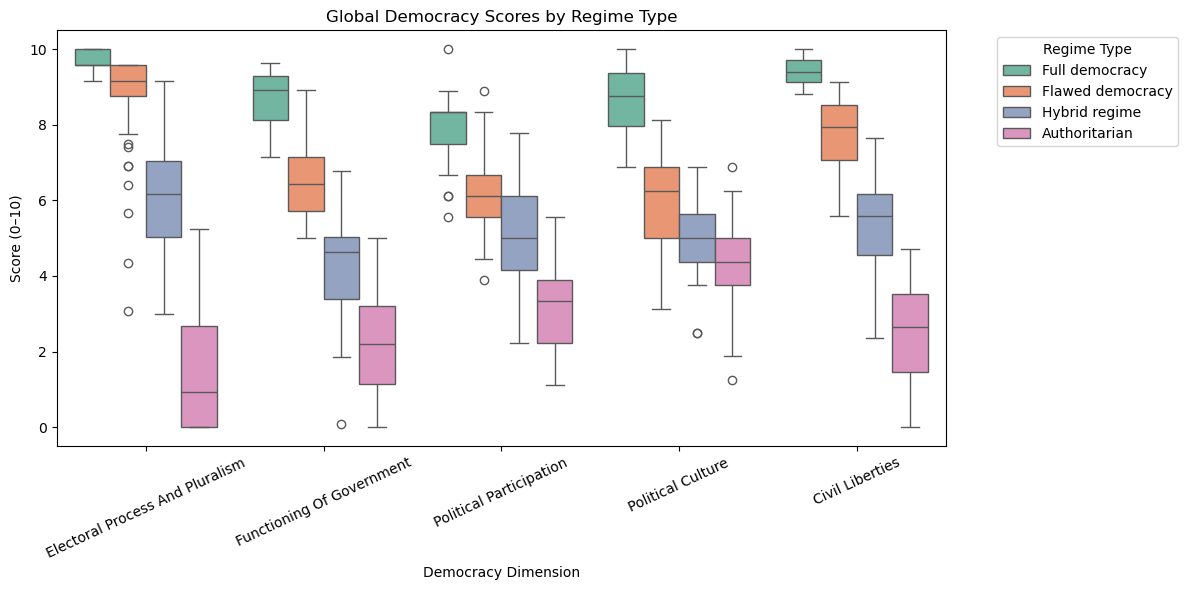

In [2]:
# 1. Import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 2. Load the dataset from local path (adjust the path if needed)
file_path = "/Users/rosalinatorres/Downloads/democracy_index.csv"
df = pd.read_csv(file_path)

# 3. Clean column names
df.columns = [col.strip().lower().replace(" ", "_") for col in df.columns]
df.rename(columns={'electoral_processand_pluralism': 'electoral_process_and_pluralism'}, inplace=True)

# 4. Define the five dimensions
dimensions = [
    'electoral_process_and_pluralism',
    'functioning_of_government',
    'political_participation',
    'political_culture',
    'civil_liberties'
]

# 5. Melt the DataFrame for visualization
df_melted = df.melt(id_vars='category', value_vars=dimensions,
                    var_name='dimension', value_name='score')

df_melted['dimension'] = df_melted['dimension'].str.replace('_', ' ').str.title()

# 6. Plot the visual
plt.figure(figsize=(12, 6))
sns.boxplot(x='dimension', y='score', hue='category', data=df_melted, palette='Set2')
plt.title('Global Democracy Scores by Regime Type')
plt.xlabel('Democracy Dimension')
plt.ylabel('Score (0–10)')
plt.legend(title='Regime Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()

### Feature engineering for political science context

Creating additional features can enhance clustering quality and interpretability:

In [6]:
# 1. Check the exact column names
print("Column names in the dataset:")
print(df.columns.tolist())

# 2. If needed, clean again (optional redundancy for safety)
df.columns = [col.strip().lower().replace(" ", "_") for col in df.columns]
df.rename(columns={'electoral_processand_pluralism': 'electoral_process_and_pluralism'}, inplace=True)

# 3. Now create the ratio features
try:
    df['liberty_governance_ratio'] = df['civil_liberties'] / (df['functioning_of_government'] + 1e-10)
    df['participation_culture_ratio'] = df['political_participation'] / (df['political_culture'] + 1e-10)
    print("\n✅ Ratio features created successfully.")
except KeyError as e:
    print(f"\n🚨 KeyError: Column not found - {e}")

Column names in the dataset:
['Unnamed: 0', 'rank', 'country', 'democracy_index', 'electoral_processand_pluralism', 'functioning_of_government', 'political_participation', 'political_culture', 'civil_liberties', 'category']

✅ Ratio features created successfully.


In [28]:
pip install adjustText

Note: you may need to restart the kernel to use updated packages.


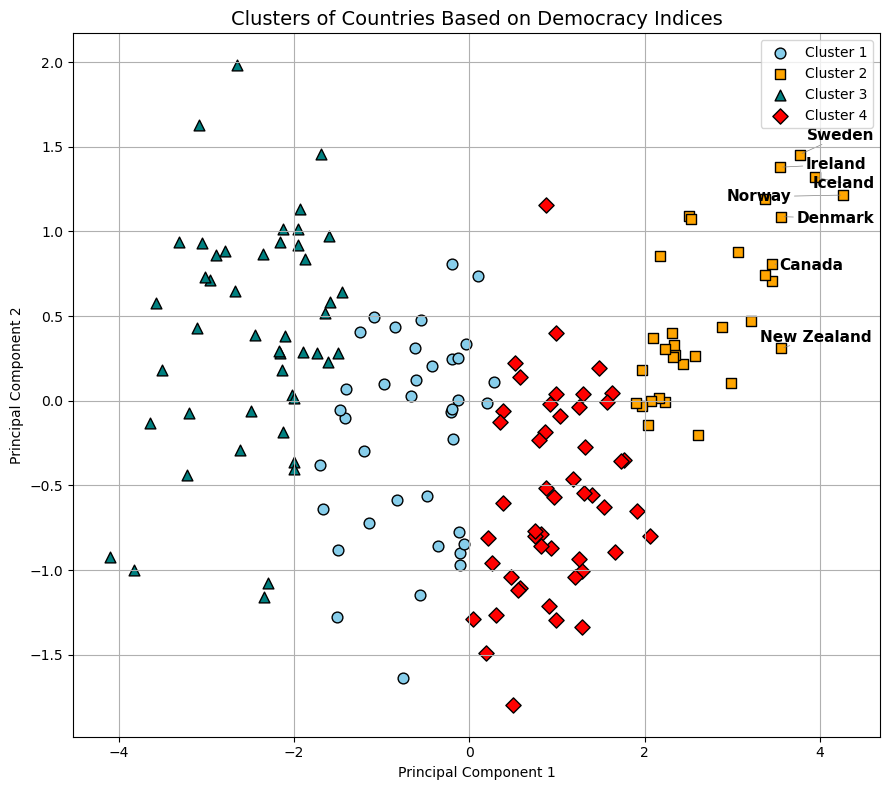

In [12]:
# 1. Imports
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from adjustText import adjust_text

# 2. Load your dataset
file_path = "/Users/rosalinatorres/Downloads/democracy_index.csv"
df = pd.read_csv(file_path)

# 3. Feature selection
features = ['electoral_processand_pluralism', 'functioning_of_government', 
            'political_participation', 'political_culture', 'civil_liberties']
X = df[features]

# 4. Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 5. PCA reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# 6. KMeans clustering
kmeans = KMeans(n_clusters=4, n_init=10, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# 7. Plotting
plt.figure(figsize=(9, 8))
colors = ['skyblue', 'orange', 'teal', 'red']
markers = ['o', 's', '^', 'D']

for i in range(4):
    plt.scatter(X_pca[clusters == i, 0], X_pca[clusters == i, 1],
                c=colors[i], marker=markers[i], label=f'Cluster {i + 1}',
                edgecolor='black', s=60)

# 8. Annotate key countries
key_countries = ['Norway', 'Sweden', 'New Zealand', 'Iceland', 'Denmark', 'Ireland', 'Canada']
texts = []
for i, country in enumerate(df['country']):
    if country in key_countries:
        texts.append(
            plt.text(X_pca[i, 0], X_pca[i, 1], country, fontsize=11, weight='bold')
        )

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

plt.title('Clusters of Countries Based on Democracy Indices', fontsize=14)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [13]:
# View PCA components and their relationship to original features
pca_components = pd.DataFrame(pca.components_, 
                              columns=features, 
                              index=['PC1', 'PC2'])
print(pca_components)

     electoral_processand_pluralism  functioning_of_government  \
PC1                        0.460488                   0.466077   
PC2                       -0.412194                   0.050638   

     political_participation  political_culture  civil_liberties  
PC1                 0.437111           0.382555         0.483021  
PC2                -0.190677           0.872259        -0.174178  


🎼 Interpretation of Your Principal Components

🧭 PC1: “Overall Democratic Quality”
	•	Strong positive loadings on all variables, especially:
	•	civil_liberties → 0.48
	•	functioning_of_government → 0.47
	•	electoral_processand_pluralism → 0.46
	•	📌 Meaning: This component is a general democracy index—higher PC1 scores suggest a nation excels broadly across all institutional pillars.

🌊 PC2: “Cultural Participation Contrast”
	•	Highest loading: political_culture → 0.87 (very dominant)
	•	Strong negative: electoral_processand_pluralism → -0.41
	•	📌 Meaning: This separates countries with strong civic culture and participation (e.g., Nordic countries) from those where formal democratic structures exist but engagement or trust is weak.

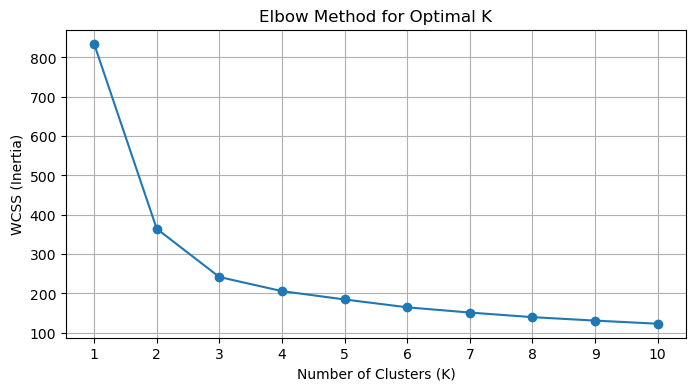


Selected Optimal K = 4


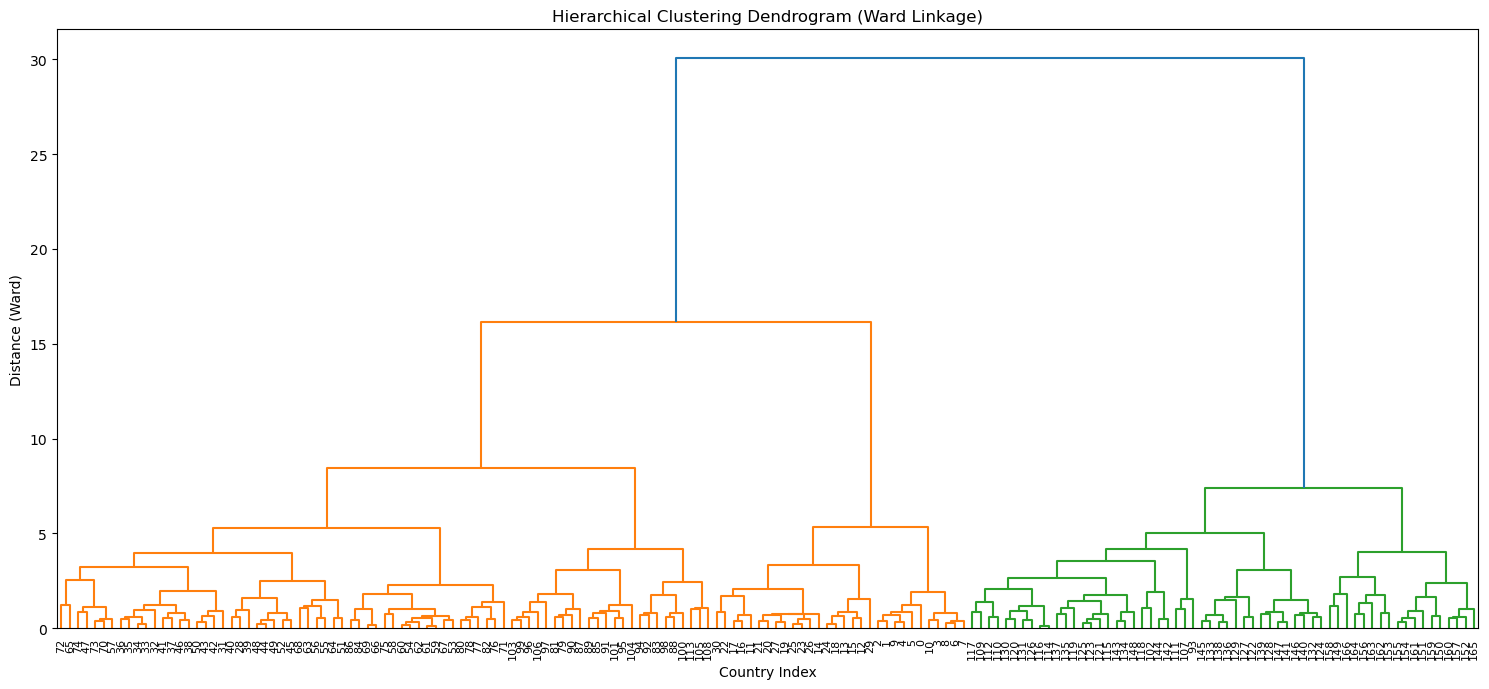


Data with Cluster Assignments:
       country        category  kmeans_cluster  hier_cluster
0       Norway  Full democracy               1             2
1      Iceland  Full democracy               1             2
2       Sweden  Full democracy               1             2
3  New Zealand  Full democracy               1             2
4      Denmark  Full democracy               1             2
5      Ireland  Full democracy               1             2
6       Canada  Full democracy               1             2
7      Finland  Full democracy               1             2
8    Australia  Full democracy               1             2
9  Switzerland  Full democracy               1             2


In [10]:
# Import necessary libraries for clustering
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import seaborn as sns

# Define the features for clustering
features = ['electoral_processand_pluralism', 'functioning_of_government', 
            'political_participation', 'political_culture', 'civil_liberties']

# Select the features to be used for clustering
X = df[features]

# Fit the scaler to the data and transform it
X_scaled = scaler.fit_transform(X)

# Calculate WCSS for a range of K values (Elbow Method)
wcss = []
K_range = range(1, 11)
for k in K_range:
    kmeans_elbow = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans_elbow.fit(X_scaled)
    wcss.append(kmeans_elbow.inertia_)

# Plot the Elbow Method graph
plt.figure(figsize=(8, 4))
plt.plot(K_range, wcss, marker='o', linestyle='-')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS (Inertia)')
plt.xticks(K_range)
plt.grid(True)
plt.show()

# Based on the EIU categories and typical results for this dataset, K=4 is expected
optimal_k = 4
print(f"\nSelected Optimal K = {optimal_k}")

# Apply K-Means with the chosen K
kmeans = KMeans(n_clusters=optimal_k, n_init=10, random_state=42)
df['kmeans_cluster'] = kmeans.fit_predict(X_scaled)

# Generate the linkage matrix using Ward's method for Hierarchical Clustering
linked = linkage(X_scaled, method='ward')

# Plot the dendrogram
plt.figure(figsize=(15, 7))
dendrogram(linked,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=False,
           leaf_rotation=90,
           leaf_font_size=8)
plt.title('Hierarchical Clustering Dendrogram (Ward Linkage)')
plt.xlabel('Country Index')
plt.ylabel('Distance (Ward)')
plt.tight_layout()
plt.show()

# Apply Agglomerative Clustering with n_clusters=4
hierarchical = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
df['hier_cluster'] = hierarchical.fit_predict(X_scaled)

# Display cluster assignments
print("\nData with Cluster Assignments:")
print(df[['country', 'category', 'kmeans_cluster', 'hier_cluster']].head(10))

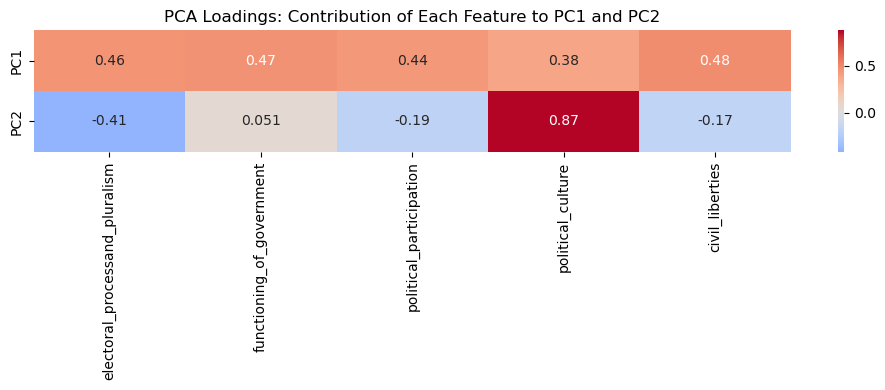

In [16]:
# Visualize PCA loadings
plt.figure(figsize=(10, 4))
sns.heatmap(pca_components, annot=True, cmap='coolwarm', center=0)
plt.title("PCA Loadings: Contribution of Each Feature to PC1 and PC2")
plt.tight_layout()
plt.show()

In [27]:
# Check the current type of the category column
print(f"Category column type: {df['category'].dtype}")
print("Sample values:")
print(df['category'].head())

# Create a mapping dictionary for categories
category_mapping = {
    'Authoritarian': 0,
    'Hybrid regime': 1,
    'Flawed democracy': 2,
    'Full democracy': 3
}

# Create a numeric version of the category column
df['category_numeric'] = df['category'].map(category_mapping)

# Now calculate confusion matrices using the numeric version
cm_kmeans = confusion_matrix(df['category_numeric'], df['kmeans_cluster'])
cm_hier = confusion_matrix(df['category_numeric'], df['hier_cluster'])

# Get category labels in the correct order for our mapping
category_labels = [k for k in sorted(category_mapping, key=category_mapping.get)]

# Create DataFrames for better readability
conf_matrix_kmeans_df = pd.DataFrame(
    cm_kmeans,
    index=category_labels,  # Rows are True EIU Categories
    columns=[f'KMeans Cluster {i}' for i in range(optimal_k)]  # Columns are Predicted Clusters
)

conf_matrix_hier_df = pd.DataFrame(
    cm_hier,
    index=category_labels,  # Rows are True EIU Categories
    columns=[f'Hier Cluster {i}' for i in range(optimal_k)]  # Columns are Predicted Clusters
)

print("\nConfusion Matrix: EIU Category vs KMeans Cluster")
print(conf_matrix_kmeans_df)

print("\nConfusion Matrix: EIU Category vs Hierarchical Cluster")
print(conf_matrix_hier_df)

Category column type: object
Sample values:
0    Full democracy
1    Full democracy
2    Full democracy
3    Full democracy
4    Full democracy
Name: category, dtype: object


KeyError: 'kmeans_cluster'

In [28]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Define and scale features
features = ['electoral_processand_pluralism', 'functioning_of_government', 
            'political_participation', 'political_culture', 'civil_liberties']
X = df[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply KMeans
kmeans = KMeans(n_clusters=4, n_init=10, random_state=42)
df['kmeans_cluster'] = kmeans.fit_predict(X_scaled)

In [29]:
from sklearn.cluster import AgglomerativeClustering

hierarchical = AgglomerativeClustering(n_clusters=4, linkage='ward')
df['hier_cluster'] = hierarchical.fit_predict(X_scaled)

These engineered features help capture democratic trade-offs and dynamism, aligning with contemporary political science perspectives that democracies often emphasize different aspects of democratic governance.

## Optimal clustering techniques for democracy data

### Determining the appropriate number of clusters

For democracy data, determining the optimal number of clusters requires both statistical validation and theoretical justification:

In [20]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

# Use elbow method to find potential optimal k values
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2, 10))
visualizer.fit(scaled_data)
visualizer.show()

# Calculate silhouette scores for range of k values
silhouette_scores = []
k_range = range(2, 10)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(scaled_data)
    silhouette_avg = silhouette_score(scaled_data, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"For n_clusters = {k}, the silhouette score is {silhouette_avg:.3f}")

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method For Optimal k')
plt.show()

NameError: name 'scaled_data' is not defined

Research indicates that democracy data often shows natural clustering at around 4-6 clusters, which often aligns with but extends beyond the four regime types in the EIU classification. Political science literature suggests that the optimal number should balance statistical measures with theoretical interpretability.

### Implementing K-means clustering

K-means is effective for identifying distinct democracy profiles:

In [10]:
# Implement K-means with optimal k (example uses 5)
optimal_k = 5  # Adjust based on your analysis
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(scaled_data)

# Add cluster labels to original dataframe
df['cluster'] = cluster_labels

# Analyze cluster characteristics
cluster_profiles = df.groupby('cluster')[dimensions].mean()
print("Cluster Profiles:")
print(cluster_profiles)

NameError: name 'scaled_data' is not defined

### Hierarchical clustering for regime relationships

Hierarchical clustering reveals relationships between different regime types, providing insight into how democracy profiles relate to each other:

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

# Calculate linkage matrix
linkage_matrix = linkage(scaled_data, method='ward')

# Plot dendrogram
plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix, labels=df['country'].values, leaf_rotation=90)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Countries')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

# Implement hierarchical clustering
hc = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
hc_labels = hc.fit_predict(scaled_data)
df['hc_cluster'] = hc_labels

The ward linkage method tends to work best for democracy data as it creates compact clusters, though complete linkage can be valuable for finding more distinctly separated regime types.

## Visualizing multidimensional democracy data

### Dimensionality reduction for exploration

Dimensionality reduction techniques help visualize the five-dimensional democracy data:

In [21]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.express as px

# PCA for basic visualization and interpretation
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
pca_df['country'] = df['country'].values
pca_df['cluster'] = df['cluster'].values
pca_df['democracy_index'] = df['democracy_index'].values

# Create scatter plot with PCA results
fig = px.scatter(
    pca_df, 
    x='PC1', 
    y='PC2',
    color='cluster',
    hover_name='country',
    size='democracy_index',
    title='PCA of Democracy Index Dimensions',
    labels={'PC1': f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)',
            'PC2': f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)'}
)

# Add biplot vectors to show how original dimensions relate to PCA
for i, feature in enumerate(dimensions):
    fig.add_shape(
        type='line',
        x0=0, y0=0,
        x1=pca.components_[0, i] * 3,
        y1=pca.components_[1, i] * 3,
        line=dict(color='red', width=1, dash='dash')
    )
    fig.add_annotation(
        x=pca.components_[0, i] * 3.2,
        y=pca.components_[1, i] * 3.2,
        text=feature,
        showarrow=False
    )

fig.show()

# t-SNE for more complex, non-linear patterns
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(scaled_data)
tsne_df = pd.DataFrame(tsne_results, columns=['t-SNE1', 't-SNE2'])
tsne_df['country'] = df['country'].values
tsne_df['cluster'] = df['cluster'].values
tsne_df['democracy_index'] = df['democracy_index'].values

fig_tsne = px.scatter(
    tsne_df, 
    x='t-SNE1', 
    y='t-SNE2',
    color='cluster',
    hover_name='country',
    size='democracy_index',
    title='t-SNE of Democracy Index Dimensions'
)

fig_tsne.show()

NameError: name 'scaled_data' is not defined

### Radar/spider charts for democracy profiles

Radar charts effectively visualize all five dimensions of democracy simultaneously, making them ideal for comparing clusters:

In [22]:
import plotly.graph_objects as go

# Create radar chart comparing cluster profiles
fig = go.Figure()

# Add each cluster as a trace
for cluster_id in range(optimal_k):
    cluster_avg = cluster_profiles.iloc[cluster_id].values
    fig.add_trace(go.Scatterpolar(
        r=cluster_avg,
        theta=dimensions,
        fill='toself',
        name=f'Cluster {cluster_id}'
    ))

# Update layout
fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 10]  # Democracy Index range
        )
    ),
    title="Democracy Index Dimension Profiles by Cluster",
    showlegend=True
)

fig.show()

NameError: name 'optimal_k' is not defined

### Geographic visualization of clusters

Map visualizations highlight spatial patterns in democracy clusters:

In [23]:
# Create choropleth map showing clusters
fig = px.choropleth(
    df,
    locations='ISO3',  # Assuming ISO3 country codes are available
    color='cluster',
    hover_name='country',
    color_discrete_sequence=px.colors.qualitative.Plotly,
    title='Democracy Clusters Worldwide',
)

fig.update_layout(
    geo=dict(
        showframe=False,
        showcoastlines=True,
        projection_type='equirectangular'
    )
)

fig.show()

ValueError: Value of 'locations' is not the name of a column in 'data_frame'. Expected one of ['Unnamed: 0', 'rank', 'country', 'democracy_index', 'electoral_processand_pluralism', 'functioning_of_government', 'political_participation', 'political_culture', 'civil_liberties', 'category', 'category_numeric'] but received: ISO3

### Visualizing transition/boundary countries

Identifying countries at cluster boundaries provides valuable insight into democratic transitions:

In [24]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

# Identify boundary/transition countries
def find_transition_countries(data, cluster_labels, n_neighbors=3):
    # Calculate distance to cluster centers
    clusters_unique = np.unique(cluster_labels)
    cluster_centers = []
    for cluster_id in clusters_unique:
        cluster_points = data[cluster_labels == cluster_id]
        cluster_centers.append(np.mean(cluster_points, axis=0))
    
    # Calculate transition scores based on neighbors from different clusters
    nn = NearestNeighbors(n_neighbors=n_neighbors)
    nn.fit(data)
    distances, indices = nn.kneighbors(data)
    
    transition_scores = []
    for i, neighbors in enumerate(indices):
        own_cluster = cluster_labels[i]
        neighbor_clusters = [cluster_labels[j] for j in neighbors]
        different_clusters = sum(1 for c in neighbor_clusters if c != own_cluster)
        transition_scores.append(different_clusters / len(neighbors))
    
    return np.array(transition_scores)

# Apply to PCA results
transition_scores = find_transition_countries(scaled_data, cluster_labels)
pca_df['transition_score'] = transition_scores

# Visualize transition countries
fig = px.scatter(
    pca_df,
    x='PC1',
    y='PC2',
    color='cluster',
    size='transition_score',  # Size by transition score
    hover_name='country',
    hover_data=['democracy_index', 'transition_score'],
    title='Democracy Index - Transition Countries',
    size_max=15
)

# Highlight top transition countries
top_transition = pca_df.nlargest(5, 'transition_score')
for i, row in top_transition.iterrows():
    fig.add_annotation(
        x=row['PC1'],
        y=row['PC2'],
        text=row['country'],
        showarrow=True,
        arrowhead=1
    )

fig.show()

NameError: name 'scaled_data' is not defined

## Interpreting clusters in political science context

### Frameworks for cluster interpretation

To interpret clusters meaningfully, connect them to political science concepts:

1. **Compare with existing regime classifications**: Cross-tabulate your clusters with the EIU's regime types to identify alignment and divergence.

2. **Analyze dimensional profiles**: Examine which dimensions are emphasized or de-emphasized in each cluster, connecting to theories of democratic trade-offs.

3. **Name clusters based on characteristics**: Create descriptive labels that reflect political characteristics rather than just statistics.

In [ ]:
# Compare clusters with official regime types
import plotly.figure_factory as ff
from sklearn.metrics import confusion_matrix, adjusted_rand_score

# Assuming 'regime_type' contains EIU classifications
regime_mapping = {
    'Full democracy': 0,
    'Flawed democracy': 1,
    'Hybrid regime': 2,
    'Authoritarian regime': 3
}
true_regimes = df['regime_type'].map(regime_mapping).values

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_regimes, cluster_labels)

# Calculate agreement score
ari = adjusted_rand_score(true_regimes, cluster_labels)

# Visualize confusion matrix
regime_labels = list(regime_mapping.keys())
cluster_labels_text = [f'Cluster {i}' for i in range(optimal_k)]

fig = ff.create_annotated_heatmap(
    z=conf_matrix,
    x=cluster_labels_text,
    y=regime_labels,
    annotation_text=conf_matrix,
    colorscale='Blues'
)

fig.update_layout(
    title=f'Comparison: Regime Types vs. Clusters (ARI: {ari:.2f})',
    xaxis_title='Predicted Clusters',
    yaxis_title='EIU Regime Types'
)

fig.show()

### Connecting clusters to democratic theory

Recent research suggests that democracies often make different trade-offs between democratic values. Your cluster analysis can reveal these patterns:

In [ ]:
# Create and visualize cluster dimensional profiles
profile_df = cluster_profiles.copy()

# Create descriptive names based on dimensional characteristics
cluster_names = []
for i, profile in profile_df.iterrows():
    # Example logic for naming (adjust based on your findings)
    if profile['electoral_process'] > 8 and profile['civil_liberties'] > 8:
        name = "Liberal Democracy"
    elif profile['functioning_govt'] > profile['political_participation'] + 2:
        name = "State-Centric Democracy"
    elif profile['political_participation'] > profile['functioning_govt'] + 2:
        name = "Participatory Democracy"
    elif profile['electoral_process'] < 4:
        name = "Electoral Autocracy"
    else:
        name = f"Cluster {i}"
    cluster_names.append(name)

profile_df['cluster_name'] = cluster_names
profile_df.set_index('cluster_name', inplace=True)

# Visualize the named clusters
ax = profile_df[dimensions].plot(kind='bar', figsize=(14, 7))
ax.set_title('Democracy Profiles by Cluster Type')
ax.set_ylabel('Standardized Score')
ax.set_xlabel('Cluster Type')
plt.legend(title='Democracy Dimension')
plt.tight_layout()
plt.show()

### Analyzing boundary and transition countries

Countries at cluster boundaries often represent transitional regimes or hybrid systems:

In [ ]:
# Identify and analyze top transition countries
transition_df = df.copy()
transition_df['transition_score'] = transition_scores
top_transitions = transition_df.nlargest(10, 'transition_score')

print("Top transition countries:")
print(top_transitions[['country', 'cluster', 'democracy_index', 'transition_score']])

# Compare their scores across dimensions
transition_profiles = top_transitions[dimensions + ['country', 'transition_score']]
transition_profiles.set_index('country', inplace=True)

# Visualize transition country profiles
ax = transition_profiles[dimensions].plot(kind='bar', figsize=(14, 7))
ax.set_title('Democracy Profiles of Top Transition Countries')
ax.set_ylabel('Score')
ax.set_xlabel('Country')
plt.legend(title='Democracy Dimension')
plt.tight_layout()
plt.show()

## Professional presentation in Jupyter notebooks

### Structured notebook organization

For a professional-quality notebook analyzing democracy data, follow this structure:

1. **Title and Introduction**
   - Clear title focusing on Democracy Index clustering analysis
   - Brief abstract summarizing purpose, methods, and key findings
   - Significance of the research question

2. **Background/Literature Review**
   - Overview of democracy measurement approaches
   - Introduction to the Democracy Index and its components
   - Relevance of clustering for understanding regime types

3. **Data Description and Preparation**
   - Detailed description of the dataset and its dimensions
   - Data cleaning procedures with clear documentation
   - Feature engineering with theoretical justification

4. **Methodology**
   - Explanation of clustering approaches
   - Parameter selection process
   - Validation techniques

5. **Analysis and Results**
   - Cluster characteristics and visualizations
   - Comparison with traditional classifications
   - Geographic and dimensional patterns

6. **Political Interpretation**
   - Connecting clusters to democratic theory
   - Analysis of transition countries
   - Implications for understanding democratic development

7. **Discussion and Limitations**
   - Critical assessment of findings
   - Methodological constraints
   - Alternative interpretations

8. **Conclusion**
   - Summary of key findings
   - Broader implications
   - Future research directions

### Narrative frameworks for political data analysis

The most compelling democracy analyses use a problem-solution-impact narrative structure:

- **Context**: Explain the complexity of measuring and categorizing democracies
- **Challenge**: Describe the limitations of threshold-based classifications
- **Solution**: Introduce clustering as a data-driven approach to identify patterns
- **Impact**: Demonstrate how the results enhance understanding of democratic systems

Frame the analysis as an investigation into the natural patterns in democracy data rather than imposing predefined categories. This approach aligns with current academic perspectives that recognize democracy as both a spectrum and a set of distinct typologies.

### Documentation and communication standards

Maintain high academic standards in your notebook:

- Clearly document all data sources and methodological decisions
- Use proper political science terminology when discussing democratic concepts
- Balance technical explanations with substantive political interpretations
- Acknowledge limitations transparently
- Cite relevant literature from both data science and political science
- Avoid partisan framing or normative judgments without theoretical grounding

### Example narrative sections

Here's an example introduction section that sets the proper tone:

In [ ]:
markdown
# Discovering Democracy Profiles: A Cluster Analysis of the EIU Democracy Index

## Introduction

The Economist Intelligence Unit's Democracy Index provides a multidimensional assessment of democratic systems worldwide, measuring countries across five key dimensions: electoral process and pluralism, functioning of government, political participation, political culture, and civil liberties. While the index categorizes countries into four regime types (full democracies, flawed democracies, hybrid regimes, and authoritarian regimes) based on threshold scores, this classification system may obscure more nuanced patterns in how democratic dimensions interact.

This analysis applies clustering techniques to identify natural groupings in democracy data that may reveal distinct "democracy profiles" - patterns in how countries emphasize or de-emphasize different aspects of democratic governance. Recent political science research suggests that democracies often make different trade-offs between democratic values, resulting in distinctive institutional arrangements that simple classification schemes might miss.

By using K-means and hierarchical clustering algorithms, we can identify these natural groupings and explore how they relate to traditional classifications, geographic patterns, and theories of democratic development. This approach allows us to move beyond viewing democracy as simply a linear progression from authoritarianism to full democracy, instead recognizing the diverse paths that political systems take.

And here's an example of connecting statistical findings to political theory:

In [ ]:
markdown
## Interpreting Democracy Clusters

Our cluster analysis reveals five distinct profiles in global democracy data. These clusters represent different patterns in how countries balance the five dimensions of democracy measured by the EIU.

Cluster 1 shows high scores in electoral process and civil liberties, but relatively lower scores in political participation and political culture. This pattern resembles what Schlenkrich (2019) describes as "libertarian-majoritarian democracy" - systems that emphasize individual freedoms and electoral mechanisms but have less emphasis on participatory elements.

Cluster 2 demonstrates consistently high scores across all dimensions, corresponding closely to the EIU's "full democracy" category but with particular strength in functioning of government. Countries in this cluster have developed robust institutional frameworks that support all aspects of democratic governance.

Cluster 3 shows an interesting pattern of moderate electoral scores combined with stronger political participation than government functioning - what might be termed "participatory-deficient democracies." These systems have developed democratic cultures and participation but lag in institutional effectiveness.

The identification of these clusters supports recent theoretical work suggesting that democracy is not simply a linear spectrum but involves different configurations of democratic elements. As Møller and Skaaning (2012) argue, democratic development often follows specific patterns where certain rights and institutions emerge before others, creating distinctive profiles during transition periods.

## Evaluating cluster quality with expert classifications

### Statistical validation methods

Beyond standard clustering metrics, political data requires domain-specific validation:

In [ ]:
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

# Compare with expert classifications
expert_labels = df['regime_type_numeric'].values  # Assuming this exists
ari = adjusted_rand_score(expert_labels, cluster_labels)
ami = adjusted_mutual_info_score(expert_labels, cluster_labels)

print(f"Adjusted Rand Index: {ari:.3f}")
print(f"Adjusted Mutual Information: {ami:.3f}")

### Robustness testing

Political classifications may be contested, so robustness analysis is crucial:

In [ ]:
# Bootstrapping for cluster stability
from sklearn.utils import resample

n_bootstraps = 100
ari_bootstrap_scores = []

for i in range(n_bootstraps):
    # Create bootstrap sample
    boot_indices = resample(range(len(scaled_data)), replace=True, 
                           n_samples=len(scaled_data), random_state=i)
    boot_data = scaled_data[boot_indices]
    
    # Cluster the bootstrap sample
    kmeans_boot = KMeans(n_clusters=optimal_k, random_state=42).fit(boot_data)
    boot_labels = kmeans_boot.labels_
    
    # Compare with original clustering
    original_labels = np.zeros_like(boot_labels)
    for j, idx in enumerate(boot_indices):
        original_labels[j] = cluster_labels[idx]
    
    ari = adjusted_rand_score(original_labels, boot_labels)
    ari_bootstrap_scores.append(ari)

print(f"Bootstrap stability - Mean ARI: {np.mean(ari_bootstrap_scores):.3f}")
print(f"Bootstrap stability - Std Dev ARI: {np.std(ari_bootstrap_scores):.3f}")

## Conclusion: Clustering for political insight

Clustering democracy data reveals patterns that might be obscured by traditional classifications. By applying appropriate preprocessing, carefully selecting clustering parameters, creating effective visualizations, and interpreting results within political science frameworks, you can develop a sophisticated analysis that contributes to understanding democratic systems worldwide.

The most valuable analyses connect statistical findings to substantive political insights, identifying not just clusters but meaningful democracy profiles that reflect how countries prioritize different aspects of democratic governance. By focusing on boundary countries and transition zones, your analysis can highlight political systems in flux and provide insight into democratic development trajectories.

A professional Jupyter notebook that balances technical rigor with clear narrative and political context will impress both academic peers and potential employers, demonstrating your ability to bridge data science techniques with domain expertise in political science.